## Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import torchvision.utils

## Define Model

In [ ]:
# Create class with 1 linear layer
# This is the ODE block that replaces residual blocks
class ODE_Func(nn.Module):
  def __init__(self, dim):
    super(ODE_Func, self).__init__()

    # Both input and output dimensions equal to 'dim'
    self.linear = nn.Linear(dim, dim)

  def forward(self, t, x):
    # Apply a tanh non-linearity to the output of linear layer.
    # Derivative
    return torch.tanh(self.linear(x))

# Create a class that uses ODE block
# Carry out ODE solver
class ODE_Block(nn.Module):
  def __init__(self, odefunc):
    super(ODE_Block, self).__init__()
    self.odefunc = odefunc

  def forward(self, x):
    # Using Euler's Method for ODE Integration
    time_start = 0
    time_end = 1
    num_steps = 100
    delta_t = (time_end - time_start) / num_steps
    t = time_start
    for _ in range(num_steps):
      x = x + delta_t * self.odefunc(t, x)
      t += delta_t
    return x

# This class creates the overall Neural Network
class ODE_CIFAR10_Model(nn.Module):
  def __init__(self):
    super(ODE_CIFAR10_Model, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # Padding 1 to maintain dimensionality
    self.pool = nn.MaxPool2d(2, 2) # Max pooling layer
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(16 * 16 * 16, 256) # input tensor shape will be 16 channels, with 16x16 image size due to max pooling
    self.ode_block = ODE_Block(ODE_Func(256)) # in --> out need to maintain 256 nodes
    self.fc2 = nn.Linear(256, 10) # output dim=10 for 10 classes in CIFAR

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = self.ode_block(x)
    x = self.fc2(x)
    x = F.softmax(x, dim=1)
    return x

## Setup Dataset

In [ ]:
# Standard transformations for PyTorch
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create and load images into dataloader - Training
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Create and load images into dataloader - Testing
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:06<00:00, 28106840.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Training

In [ ]:
# Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate model, loss function, optimizer
model = ODE_CIFAR10_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda


In [ ]:
num_epochs = 15
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):

  # ------------------TRAINING------------------------------
  model.train()
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data[0].to(device), data[1].to(device) # send inputs to GPU
    optimizer.zero_grad() # Collect gradients at each layer
    outputs = model(inputs) # Forward prop
    loss = criterion(outputs, labels) # Calculate loss
    loss.backward() # Backprop updates
    optimizer.step()  # Backprop

    running_loss += loss.item()

  # Get avg loss
  avg_loss = running_loss / len(trainloader)
  train_losses.append(avg_loss)
  print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

  # ------------------VALIDATION----------------------------
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for data in testloader:

      images, labels = data[0].to(device), data[1].to(device) # send inputs to GPU
      # Forward prop
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      # Calculate metrics
      correct += (predicted == labels).sum().item()

  # Get avg accuracy
  val_accuracy = 100 * correct / total
  val_accuracies.append(val_accuracy)
  print(f'Epoch {epoch + 1} done. Accuracy on test set: {val_accuracy:.2f}%')

print('Finished Training')

Epoch [1/15], Loss: 2.1869
Epoch 1 done. Accuracy on test set: 36.26%
Epoch [2/15], Loss: 2.0765
Epoch 2 done. Accuracy on test set: 41.06%
Epoch [3/15], Loss: 2.0290
Epoch 3 done. Accuracy on test set: 46.36%
Epoch [4/15], Loss: 1.9891
Epoch 4 done. Accuracy on test set: 49.21%
Epoch [5/15], Loss: 1.9532
Epoch 5 done. Accuracy on test set: 51.19%
Epoch [6/15], Loss: 1.9221
Epoch 6 done. Accuracy on test set: 54.31%
Epoch [7/15], Loss: 1.8942
Epoch 7 done. Accuracy on test set: 56.20%
Epoch [8/15], Loss: 1.8723
Epoch 8 done. Accuracy on test set: 57.81%
Epoch [9/15], Loss: 1.8506
Epoch 9 done. Accuracy on test set: 56.84%
Epoch [10/15], Loss: 1.8312
Epoch 10 done. Accuracy on test set: 59.85%
Epoch [11/15], Loss: 1.8125
Epoch 11 done. Accuracy on test set: 60.23%
Epoch [12/15], Loss: 1.7933
Epoch 12 done. Accuracy on test set: 59.93%
Epoch [13/15], Loss: 1.7789
Epoch 13 done. Accuracy on test set: 61.50%
Epoch [14/15], Loss: 1.7636
Epoch 14 done. Accuracy on test set: 61.78%
Epoch [15/

## Plot Loss / Accuracy

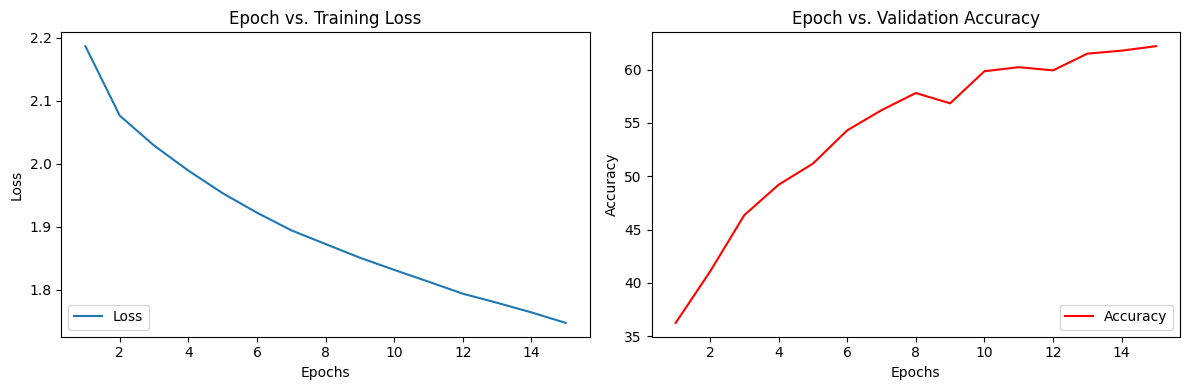

In [ ]:
# Plot all losses and accuracies
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs. Training Loss')
plt.legend(loc='lower left')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs. Validation Accuracy')

plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

## Generate Confusion Matrix

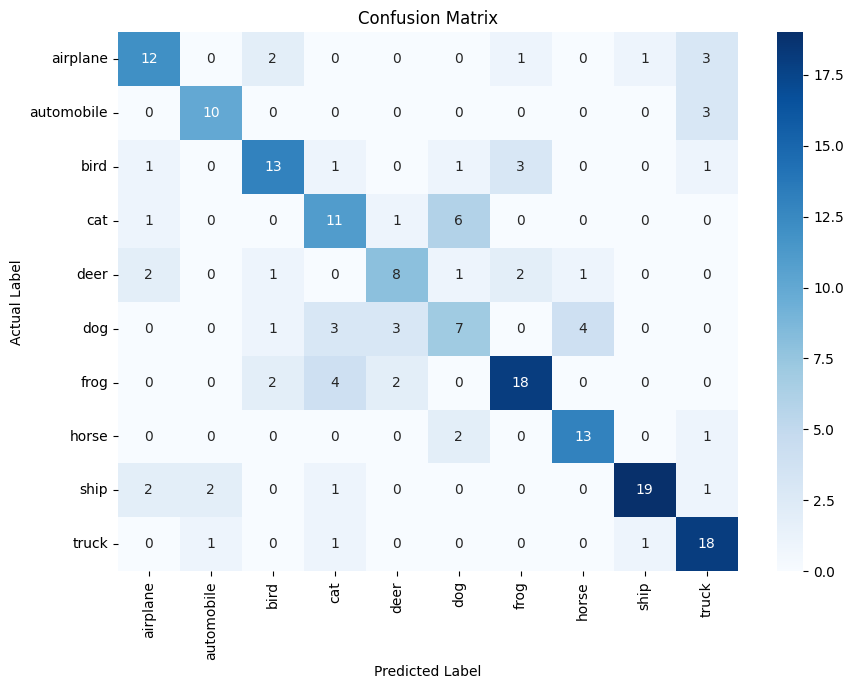

In [ ]:
y_pred = []
y_true = []

# Process first 2 batches from testing dataset
for i, data in enumerate(testloader, 0):

  # Stop after processing 2 batches
  # 64 * 2 = 128 images
  if i >= 3:
    break

  # get data
  images, labels = data
  images, labels = images.to(device), labels.to(device)

  # Run inference
  outputs = model(images)
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())
  y_true.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Calculate precision, recall, and accuracy
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Precision: 0.6671
Recall: 0.6674
Accuracy: 0.6719


## View Model Inference

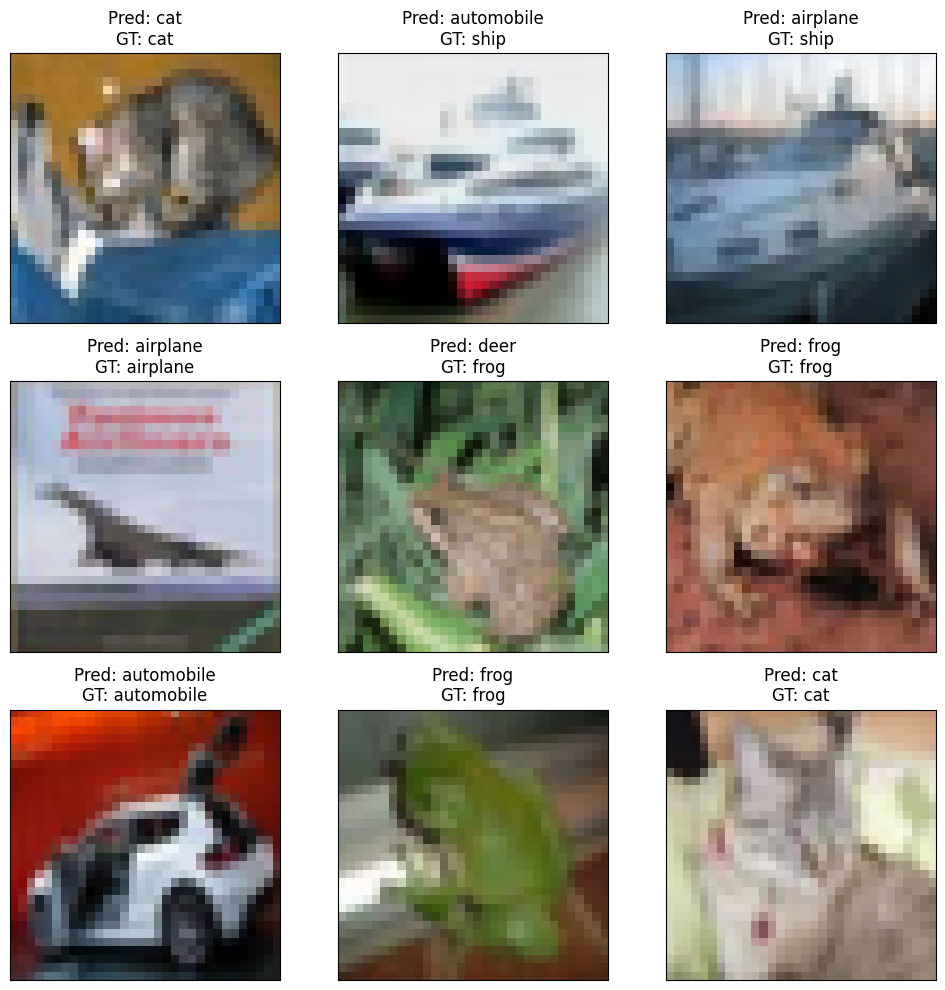

In [ ]:
# Function to convert tensor image for plotting
def show_image(img, ax):
  img = img / 2 + 0.5  # Unnormalize
  np_img = img.cpu().numpy()
  ax.imshow(np.transpose(np_img, (1, 2, 0)))

# Get batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Run inference
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):

  if i >= len(images):
    break

  show_image(images[i], ax)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f"Pred: {trainset.classes[predicted[i]]}\nGT: {trainset.classes[labels[i]]}")

plt.tight_layout()
plt.show()